# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

## Setting-up case with different resolutions

IC are the bump from the Rossby adjustment case

In [4]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.RossbyInit import *
from utils.WindPerturb import *

In [5]:
ls = [6, 7, 8, 9, 10]

Text(0.5, 0.75, 'Initial Conditions')

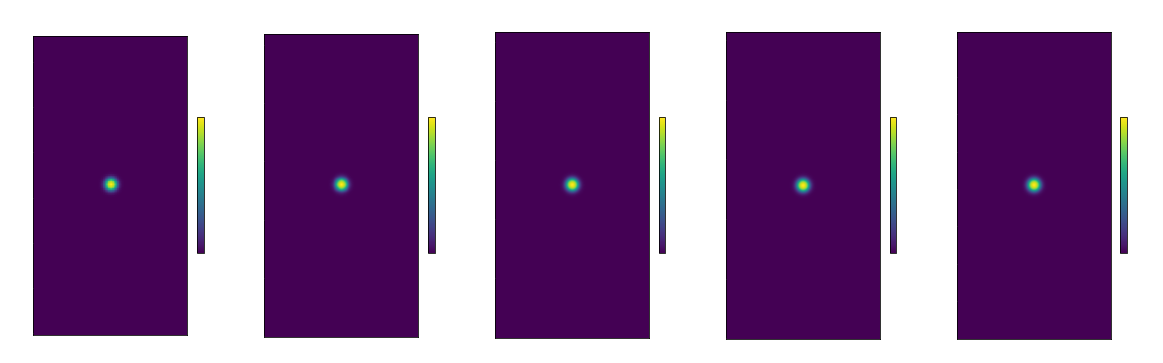

In [6]:
fig, axs = plt.subplots(1,len(ls), figsize=(20,10))

for l_idx, l in enumerate(ls):
    data_args = initLevel(l)
    im = axs[l_idx].imshow(data_args["eta0"])
    plt.colorbar(im, ax=axs[l_idx], shrink=0.25)

plt.suptitle("Initial Conditions", y=0.75)

### (Deterministic) Simulation on different Resolutions

In [7]:
T = 125000

In [8]:
for l_idx, l  in enumerate(ls):
    data_args = initLevel(l)
    exec("sim"+str(l_idx)+" = CDKLM16.CDKLM16(gpu_ctx, **data_args)")
    exec("sim"+str(l_idx)+".step(T)")

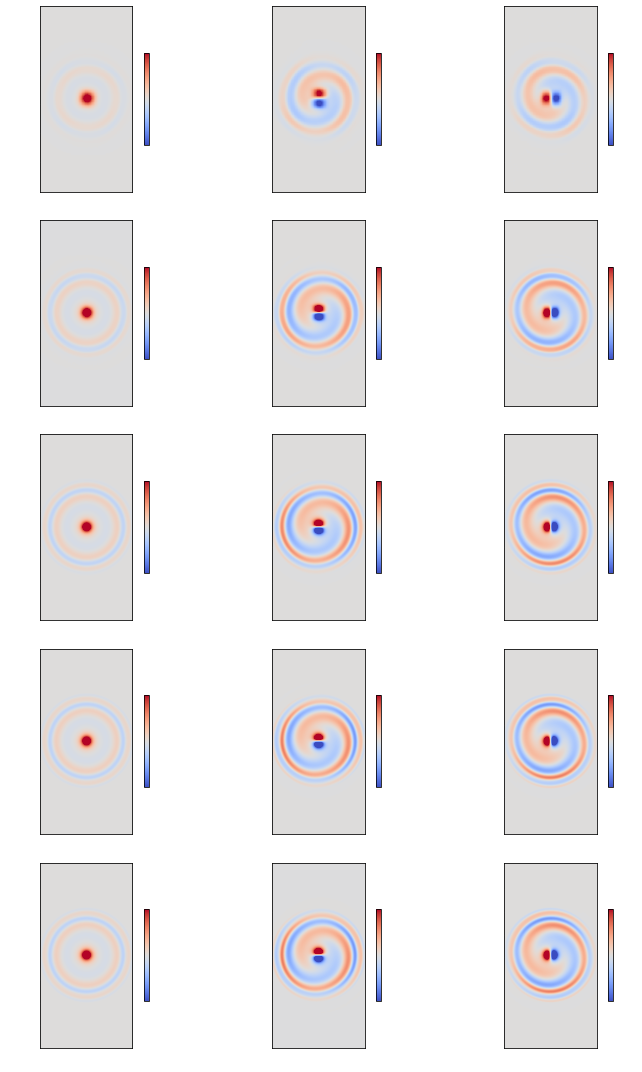

In [9]:
fig, axs = plt.subplots(len(ls),3, figsize=(10,15))

for j in range(len(ls)):
    for i in range(3):
        if i == 0: 
            vlim = 0.05
        else: 
            vlim = 2
        im = axs[j,i].imshow(eval("sim"+str(j)).download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
        plt.colorbar(im, ax=axs[j,i], shrink=0.5)
plt.tight_layout()

### Perturbation from wind direction

Wind field is faded out towards the walls. 
*So far only one random parameter but Matern field of wind intended.*

In [10]:
wind_N = 100
t_splits = 26

In [50]:
KLSampler = KarhunenLoeve_Sampler(t_splits, wind_N, decay=1.15, scaling=3)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

In [53]:
wind = wind_sample(KLSampler, T, wind_weight=wind_weight, wind_speed=0.0)

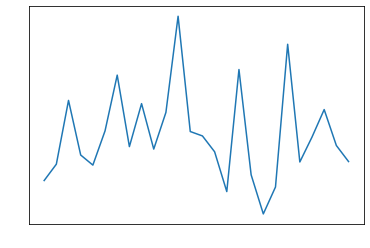

In [61]:
plt.plot(wind.wind_u[:,50,50])

Text(0.5, 1.0, 'wind_v')

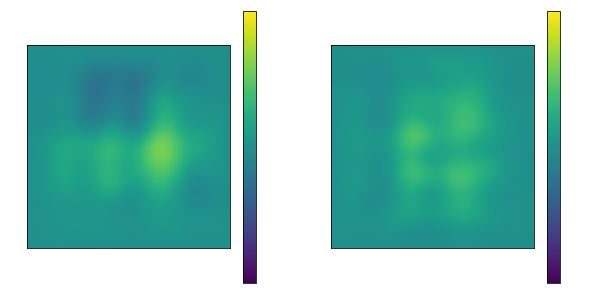

In [54]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

wind_t = 10

im = axs[0].imshow(wind.wind_u[wind_t], vmin=-10, vmax=10)
plt.colorbar(im, ax=axs[0], shrink=0.5)
axs[0].set_title("wind_u")

im = axs[1].imshow(wind.wind_v[wind_t], vmin=-10, vmax=10)
plt.colorbar(im, ax=axs[1], shrink=0.5)
axs[1].set_title("wind_v")


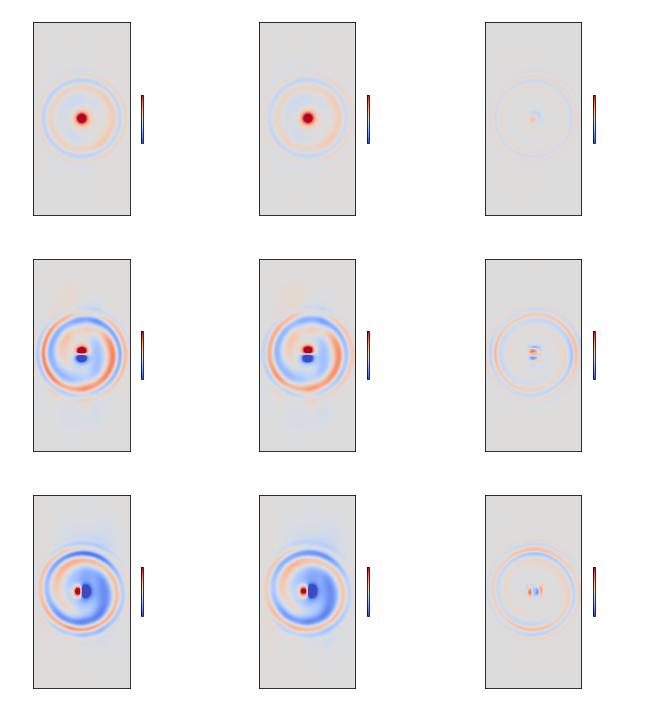

In [56]:
# Fine sim
l = 8
data_args = initLevel(l)
sim0 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim0.step(T)

# Coarse partner
data_args = initLevel(l-1)
sim1 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim1.step(T)


fig, axs = plt.subplots(3,3, figsize=(10,10))
labels = ["eta", "hu", "hv"]
for i in range(3):
    if i == 0: 
        vlim = 0.05
    else: 
        vlim = 2
    im = axs[i,0].imshow(sim0.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,0], shrink=0.25)
    axs[i,0].set_title("Fine "+labels[i])
    im = axs[i,1].imshow(sim1.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,1], shrink=0.25)
    axs[i,1].set_title("Coarse "+labels[i])

    im = axs[i,2].imshow(sim0.download(interior_domain_only=True)[i] - sim1.download(interior_domain_only=True)[i].repeat(2,0).repeat(2,1), vmin=-0.5*vlim, vmax=0.5*vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,2], shrink=0.25)
    axs[i,2].set_title("Difference "+labels[i])

plt.tight_layout()

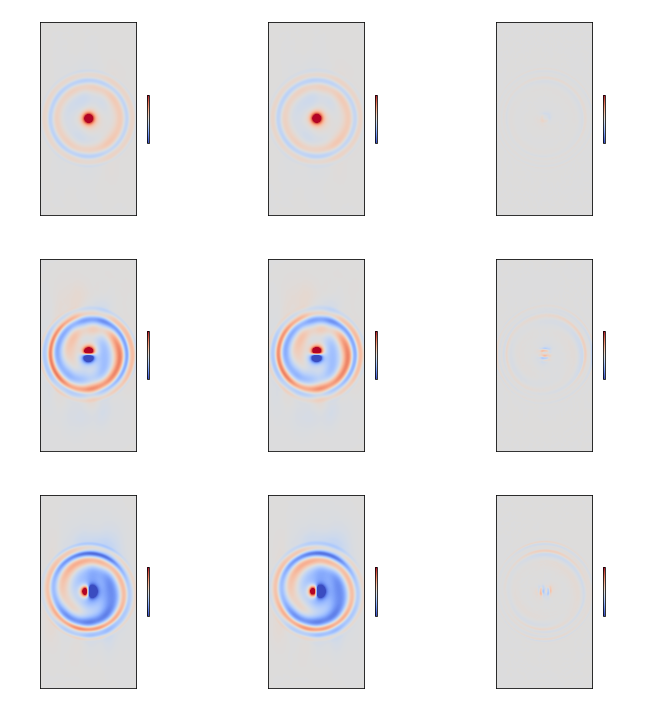

In [57]:
# Fine sim
l = 9
data_args = initLevel(l)
sim0 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim0.step(T)

# Coarse partner
data_args = initLevel(l-1)
sim1 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim1.step(T)


fig, axs = plt.subplots(3,3, figsize=(10,10))
labels = ["eta", "hu", "hv"]
for i in range(3):
    if i == 0: 
        vlim = 0.05
    else: 
        vlim = 2
    im = axs[i,0].imshow(sim0.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,0], shrink=0.25)
    axs[i,0].set_title("Fine "+labels[i])
    im = axs[i,1].imshow(sim1.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,1], shrink=0.25)
    axs[i,1].set_title("Coarse "+labels[i])

    im = axs[i,2].imshow(sim0.download(interior_domain_only=True)[i] - sim1.download(interior_domain_only=True)[i].repeat(2,0).repeat(2,1), vmin=-0.5*vlim, vmax=0.5*vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,2], shrink=0.25)
    axs[i,2].set_title("Difference "+labels[i])

plt.tight_layout()

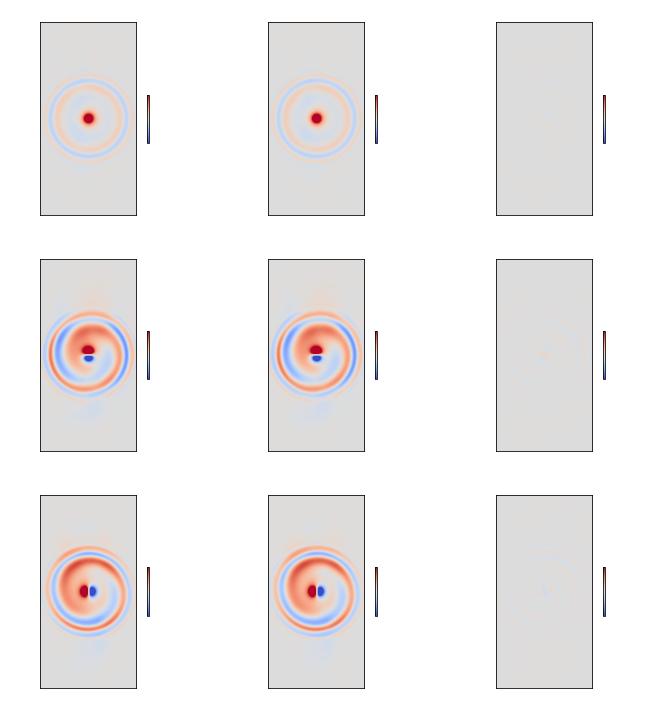

In [39]:
# Fine sim
l = 10
data_args = initLevel(l)
sim0 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim0.step(T)

# Coarse partner
data_args = initLevel(l-1)
sim1 = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind)
sim1.step(T)


fig, axs = plt.subplots(3,3, figsize=(10,10))
labels = ["eta", "hu", "hv"]
for i in range(3):
    if i == 0: 
        vlim = 0.05
    else: 
        vlim = 2
    im = axs[i,0].imshow(sim0.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,0], shrink=0.25)
    axs[i,0].set_title("Fine "+labels[i])
    im = axs[i,1].imshow(sim1.download(interior_domain_only=True)[i], vmin=-vlim, vmax=vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,1], shrink=0.25)
    axs[i,1].set_title("Coarse "+labels[i])

    im = axs[i,2].imshow(sim0.download(interior_domain_only=True)[i] - sim1.download(interior_domain_only=True)[i].repeat(2,0).repeat(2,1), vmin=-0.5*vlim, vmax=0.5*vlim, cmap="coolwarm")
    plt.colorbar(im, ax=axs[i,2], shrink=0.25)
    axs[i,2].set_title("Difference "+labels[i])

plt.tight_layout()